# Character Classification - Data Mining
Simple UI for creating data for character classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
# Import Widgets
from ipywidgets import Button, Text, HBox, VBox
from IPython.display import display, clear_output
# Timestamp
import time

# Import costume functions, corresponding to notebooks
from detect import page, words, charSeg

Loading tf model:
INFO:tensorflow:Restoring parameters from models/CNN-CG


## Hepl functions

In [2]:
SMALL_HEIGHT = 800
IMG = "text"

def implt(img, cmp=None, t=''):
    """ Show image using plt """
    plt.imshow(img, cmap=cmp)
    plt.title(t)
    plt.show()


def resize(img, height=SMALL_HEIGHT, allways=False):
    """ Resize image to given height """
    if (img.shape[0] > SMALL_HEIGHT or allways):
        rat = height / img.shape[0]
        return cv2.resize(img, (int(rat * img.shape[1]), height))
    
    return img


def ratio(img, height=SMALL_HEIGHT):
    return img.shape[0] / height

## Load image

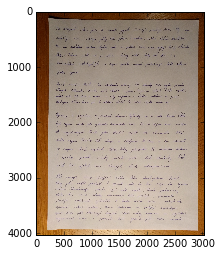

In [3]:
image = cv2.cvtColor(cv2.imread("data/pagedet/%s.jpg" % IMG), cv2.COLOR_BGR2RGB)
implt(image)

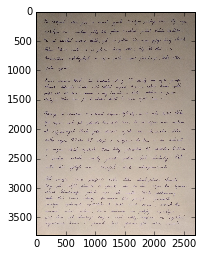

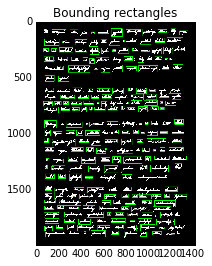

In [4]:
crop = page.detection(image)
implt(crop)
bBoxes = words.detection(crop)

## Simple UI using widgets

## Preprocessing

In [5]:
def wordTilt(img, height):
    edges = cv2.Canny(img, 50, 150, apertureSize = 3)
    lines = cv2.HoughLines(edges, 1, np.pi/180, 30)
    
    if lines is not None:
        meanAngle = 0
        # Set min number of valid lines (try higher)
        numLines = np.sum(1 for l in lines if l[0][1] < 0.7 or l[0][1] > 2.6)
        if numLines > 1:
            meanAngle = np.median([l[0][1] for l in lines if l[0][1] < 0.7 or l[0][1] > 2.6])

        # Look for angle with correct value
        if meanAngle != 0 and (meanAngle < 0.7 or meanAngle > 2.6):
            img = tiltByAngle(img, meanAngle, height)
    
    return cropAddBorder(img, height, 50)

        
def tiltByAngle(img, angle, height):
    dist = np.tan(angle) * height
    width = len(img[0])
    sPoints = np.float32([[0,0], [0,height], [width,height], [width,0]])
    
    # Dist is positive for angle < 0.7; negative for angle > 2.6
    # Image must be shifed to right
    if dist > 0:
        tPoints = np.float32([[0,0], [dist,height], [width+dist,height], [width,0]])
    else:
        tPoints = np.float32([[-dist,0], [0,height], [width,height], [width-dist,0]])

    M = cv2.getPerspectiveTransform(sPoints, tPoints)
    return cv2.warpPerspective(img, M, (int(width+abs(dist)), height))


def sobelDetect(channel):
    """ The Sobel Operator"""
    sobelX = cv2.Sobel(channel, cv2.CV_16S, 1, 0)
    sobelY = cv2.Sobel(channel, cv2.CV_16S, 0, 1)
    # Combine x, y gradient magnitudes sqrt(x^2 + y^2)
    sobel = np.hypot(sobelX, sobelY)
    sobel[sobel > 255] = 255
    return sobel


def imgPreprocess(image, height):
    """ Preprocess image for """
    # @TODO - Need speed up -> configure bilateral fileter
    img = cv2.bilateralFilter(image, 0, 30, 30)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
 
    # @TODO Can try only revers colors on grayscale image
    # reversGray = cv2.bitwise_not(gray)

    edges = np.uint8(sobelDetect(gray))
    ret,th = cv2.threshold(edges, 50, 255, cv2.THRESH_TOZERO)
    return wordTilt(th, height)


def cropAddBorder(img, height, tol=0):
    # Clear small values
    img[img < 40] = 0
    # Mask of pixels brighter than tolerance
    mask = img > tol
    coords = np.argwhere(mask)
    # Bounding box of non-black pixels.
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1   # slices are exclusive at the top
    # Croping image
    resize(img[x0:x1, y0:y1], height, True), 
    return cv2.copyMakeBorder(img, 0, 0, 15, 15, cv2.BORDER_CONSTANT, value=[0, 0, 0])

In [6]:
class Cycler:
    """ Cycle through the chars, save data """
    height = 60
    
    def __init__(self, image, boxes, idx):
        self.boxes = boxes       # Array of bounding boxes
        self.image = image       # Whole image
        self.index = idx         # Index of current bounding box
        self.charIdx = 0         # Position po slider
        self.actual = image      # Current image of word
        self.actualChar = image  # Current slider image
        self.nextImg()
        
    def save(self, b, val=1):
        """ Saving current position of slider"""
        
        cv2.imwrite("data/gapdet/%s/%s.jpg" % (val, time.time()), self.actualPos)
        self.nextChar()
        
    def nextChar(self, b=None):
        """ Sliding over image """        
        # Clearing jupyter output for new image
        clear_output()
        idx = self.charIdx
        gaps = self.gaps
        
        if idx < len(gaps) - 1:            
            img = self.actual[0:self.height, gaps[idx]:gaps[idx+1]]
            implt(img, 'gray')
            self.charIdx += 1
        else:
            if self.nextImg() == -1:
                print("END")

    def nextImg(self, b=None):
        """ Getting next image from the array """
        clear_output()
        self.charIdx = 0
        if self.index < len(self.boxes):
            b = self.boxes[self.index]
            x1, y1, x2, y2 = b
            
            # Cuting out the word image and resizing to standard height
            img = self.image[y1:y2, x1:x2]
            img = resize(img, self.height, True)
            
            implt(img, t='Index: ' + str(self.index))            
            self.actual = imgPreprocess(img, self.height)
            
            self.gaps = charSeg.segmentation(self.actual)
            
            self.index += 1
            return 0
        else:
            print("END")
            return -1

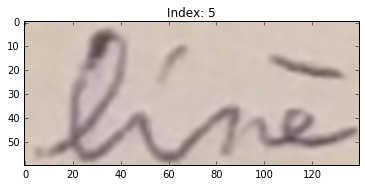

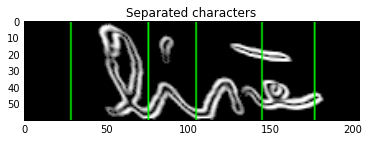

In [11]:
#  Last index
#  Last word: rijnovem
LAST_INDEX = 1
# Class cycling through text positions
cycler = Cycler(crop, bBoxes, LAST_INDEX)

def handle_submit(sender):
    print(sender.value)


    

tSaver = Text(description="Save Char")
bNex = Button(description="Next Char")
bNexi = Button(description="Next Image")

tSaver.on_submit(handle_submit)
bNex.on_click(cycler.nextChar)
bNexi.on_click(cycler.nextImg)

VBox([tSaver, HBox([bNexi, bNex])])

In [ ]:
### RULES FOR CREATING DATASET ###
#
#  Label every image
#  Slider is moving by 2px
#  For each gap creat max. 3 images (before, center, after)
#
###################################

### Space for Notes ###
#
#  Try to tilt the sliding frame
#  Or when separated, tilt saparation lines +/- 45°,
#  so that it minimize the crossing pixels
#  (maximize number of white pixels in region...)
#  I'm able to create 300 data images / 30 min
#
#######################